# **Setup**

In [1]:
import pandas as pd
import numpy as np

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# **Mixed data types**
Our Synthea generated "medications.csv" contains data related to the medications of the patients. The task on this dataset is to predict the medication that the patient should follow.

## **Option 1:** 
Use Google Drive space to load the ".CSV".

If you are using Google Colab, change the `Runtime > Change runtime type > Hardware accelerator > GPU`, so the training later on will be faster. 

Link your Google Drive account to the Google Colab notebook.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Find the correct directory using common bash commands starting with exclamation mark (e.g. `!ls`, `!pwd`)

In [3]:
cd drive/MyDrive/Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


Check if the `medications.csv` exists.

In [4]:
import os.path
os.path.isfile("medications.csv")

True

In [5]:
synthea = pd.read_csv("medications.csv")
synthea.head()

,START,STOP,PATIENT,PAYER,ENCOUNTER,CODE,DESCRIPTION,BASE_COST,PAYER_COVERAGE,DISPENSES,TOTALCOST,REASONCODE,REASONDESCRIPTION
0,2012-03-01T06:14:03Z,2012-03-22T06:14:03Z,7d3e489a-7789-9cd6-2a1b-711074af481b,d47b3510-2895-3b70-9897-342d681c769d,d989eaad-4105-1f1b-62f3-bb15e024ec2c,562251,Amoxicillin 250 MG / Clavulanate 125 MG Oral T...,24.26,0.0,1,24.26,444814009.0,Viral sinusitis (disorder)
1,2013-05-08T00:17:55Z,2013-05-19T00:17:55Z,3829c803-1f4c-74ed-0d8f-36e502cadd0f,6e2f1a2d-27bd-3701-8d08-dae202c58632,a4f8f0e3-a654-96ec-f154-a95119683058,834061,Penicillin V Potassium 250 MG Oral Tablet,32.88,0.0,1,32.88,43878008.0,Streptococcal sore throat (disorder)
2,2013-11-02T00:43:55Z,2014-01-01T00:43:55Z,3829c803-1f4c-74ed-0d8f-36e502cadd0f,6e2f1a2d-27bd-3701-8d08-dae202c58632,ef0554c1-eca1-9f75-b5d3-44b432766db9,313820,Acetaminophen 160 MG Chewable Tablet,6.18,0.0,2,12.36,NaN,NaN
3,2018-05-22T06:14:03Z,2018-05-22T06:14:03Z,7d3e489a-7789-9cd6-2a1b-711074af481b,d47b3510-2895-3b70-9897-342d681c769d,87cae904-0417-df2f-99ac-65baf83cc201,896209,60 ACTUAT Fluticasone propionate 0.25 MG/ACTUA...,25.67,0.0,1,25.67,185086009.0,Chronic obstructive bronchitis (disorder)
4,2018-05-22T06:14:03Z,2019-05-28T06:14:03Z,7d3e489a-7789-9cd6-2a1b-711074af481b,d47b3510-2895-3b70-9897-342d681c769d,87cae904-0417-df2f-99ac-65baf83cc201,896209,60 ACTUAT Fluticasone propionate 0.25 MG/ACTUA...,34.82,0.0,12,417.84,185086009.0,Chronic obstructive bronchitis (disorder)


## **Option 2:** 
Use Local space to load the ".CSV".

In the PyVertical repo, the `medications.csv` file is at `PyVertical/data/medication.csv`. If you are currently at `PyVertical/examples`, you can follow the example below without any modification to the code.

In [ ]:
synthea = pd.read_csv("../data/medications.csv")
synthea.head()

# **Continue**
After loading the file successfully and Displaying the First 5 Records of the file.

Display the values of the dataset

In [6]:
synthea.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250620 entries, 0 to 250619
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   START              250620 non-null  object 
 1   STOP               236572 non-null  object 
 2   PATIENT            250620 non-null  object 
 3   PAYER              250620 non-null  object 
 4   ENCOUNTER          250620 non-null  object 
 5   CODE               250620 non-null  int64  
 6   DESCRIPTION        250620 non-null  object 
 7   BASE_COST          250620 non-null  float64
 8   PAYER_COVERAGE     250620 non-null  float64
 9   DISPENSES          250620 non-null  int64  
 10  TOTALCOST          250620 non-null  float64
 11  REASONCODE         202454 non-null  float64
 12  REASONDESCRIPTION  202454 non-null  object 
dtypes: float64(4), int64(2), object(7)
memory usage: 24.9+ MB


You can see that there are some missing values, some columns have "250,620" values, where some others have "202,454".

For this proof-of-concept, we remove the rows with empty values.

In [7]:
synthea.dropna(
    axis=0,
    how='any',
    thresh=None,
    subset=None,
    inplace=True
)

Display again the values of the dataset, to verify that the empty rows have been removed successfully.

In [8]:
synthea.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195032 entries, 0 to 250616
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   START              195032 non-null  object 
 1   STOP               195032 non-null  object 
 2   PATIENT            195032 non-null  object 
 3   PAYER              195032 non-null  object 
 4   ENCOUNTER          195032 non-null  object 
 5   CODE               195032 non-null  int64  
 6   DESCRIPTION        195032 non-null  object 
 7   BASE_COST          195032 non-null  float64
 8   PAYER_COVERAGE     195032 non-null  float64
 9   DISPENSES          195032 non-null  int64  
 10  TOTALCOST          195032 non-null  float64
 11  REASONCODE         195032 non-null  float64
 12  REASONDESCRIPTION  195032 non-null  object 
dtypes: float64(4), int64(2), object(7)
memory usage: 20.8+ MB


We can continue with the the data loading into Tensorflow. Additionally, we chose the field that we want to use for the prediction. In our case this is the "`CODE`" field.

In [9]:
synthea_features = synthea.copy()
synthea_labels = synthea_features.pop('CODE')

Because of the different data types and ranges you can't simply stack the features into  NumPy array and pass it to a `keras.Sequential` model. Each column needs to be handled individually. 

As one option, you could preprocess your data offline (using any tool you like) to convert categorical columns to numeric columns, then pass the processed output to your TensorFlow model. The disadvantage to that approach is that if you save and export your model the preprocessing is not saved with it. The `experimental.preprocessing` layers avoid this problem because they're part of the model.

In this example, you'll build a model that implements the preprocessing logic using [Keras functional API](https://www.tensorflow.org/guide/keras/functional.ipynb). You could also do it by [subclassing](https://www.tensorflow.org/guide/keras/custom_layers_and_models).

The functional API operates on "symbolic" tensors. Normal "eager" tensors have a value. In contrast these "symbolic" tensors do not. Instead they keep track of which operations are run on them, and build representation of the calculation, that you can run later. Here's a quick example:

In [10]:
# Create a symbolic input
input = tf.keras.Input(shape=(), dtype=tf.float32)

# Do a calculation using is
result = 2*input + 1

# the result doesn't have a value
result

<tf.Tensor 'AddV2:0' shape=(None,) dtype=float32>

In [11]:
calc = tf.keras.Model(inputs=input, outputs=result)

In [12]:
print(calc(1).numpy())
print(calc(2).numpy())

3.0
5.0


To build the preprocessing model, start by building a set of symbolic `keras.Input` objects, matching the names and data-types of the CSV columns.

In [13]:
inputs = {}

for name, column in synthea_features.items():
  dtype = column.dtype
  if dtype == object:
    dtype = tf.string
  else:
    dtype = tf.float32

  inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)

inputs

{'BASE_COST': <tf.Tensor 'BASE_COST:0' shape=(None, 1) dtype=float32>,
 'DESCRIPTION': <tf.Tensor 'DESCRIPTION:0' shape=(None, 1) dtype=string>,
 'DISPENSES': <tf.Tensor 'DISPENSES:0' shape=(None, 1) dtype=float32>,
 'ENCOUNTER': <tf.Tensor 'ENCOUNTER:0' shape=(None, 1) dtype=string>,
 'PATIENT': <tf.Tensor 'PATIENT:0' shape=(None, 1) dtype=string>,
 'PAYER': <tf.Tensor 'PAYER:0' shape=(None, 1) dtype=string>,
 'PAYER_COVERAGE': <tf.Tensor 'PAYER_COVERAGE:0' shape=(None, 1) dtype=float32>,
 'REASONCODE': <tf.Tensor 'REASONCODE:0' shape=(None, 1) dtype=float32>,
 'REASONDESCRIPTION': <tf.Tensor 'REASONDESCRIPTION:0' shape=(None, 1) dtype=string>,
 'START': <tf.Tensor 'START:0' shape=(None, 1) dtype=string>,
 'STOP': <tf.Tensor 'STOP:0' shape=(None, 1) dtype=string>,
 'TOTALCOST': <tf.Tensor 'TOTALCOST:0' shape=(None, 1) dtype=float32>}

The first step in your preprocessing logic is to concatenate the numeric inputs together, and run them through a normalization layer:

In [14]:
numeric_inputs = {name:input for name,input in inputs.items()
                  if input.dtype==tf.float32}

x = layers.Concatenate()(list(numeric_inputs.values()))
norm = preprocessing.Normalization()
norm.adapt(np.array(synthea[numeric_inputs.keys()]))
all_numeric_inputs = norm(x)

all_numeric_inputs

<tf.Tensor 'normalization/truediv:0' shape=(None, 5) dtype=float32>

Collect all the symbolic preprocessing results, to concatenate them later.

In [15]:
preprocessed_inputs = [all_numeric_inputs]

For the string inputs use the `preprocessing.StringLookup` function to map from strings to integer indices in a vocabulary. Next, use `preprocessing.CategoryEncoding` to convert the indexes into `float32` data appropriate for the model. 

The default settings for the `preprocessing.CategoryEncoding` layer create a one-hot vector for each input. A `layers.Embedding` would also work. See the [preprocessing layers guide](https://www.tensorflow.org/guide/keras/preprocessing_layers#quick_recipes) and [tutorial](../structured_data/preprocessing_layers.ipynb) for more on this topic.

In [16]:
for name, input in inputs.items():
  if input.dtype == tf.float32:
    continue
  
  lookup = preprocessing.StringLookup(vocabulary=np.unique(synthea_features[name]))
  one_hot = preprocessing.CategoryEncoding(max_tokens=lookup.vocab_size())

  x = lookup(input)
  x = one_hot(x)
  preprocessed_inputs.append(x)

With the collection of `inputs` and `processed_inputs`, you can concatenate all the preprocessed inputs together, and build a model that handles the preprocessing:

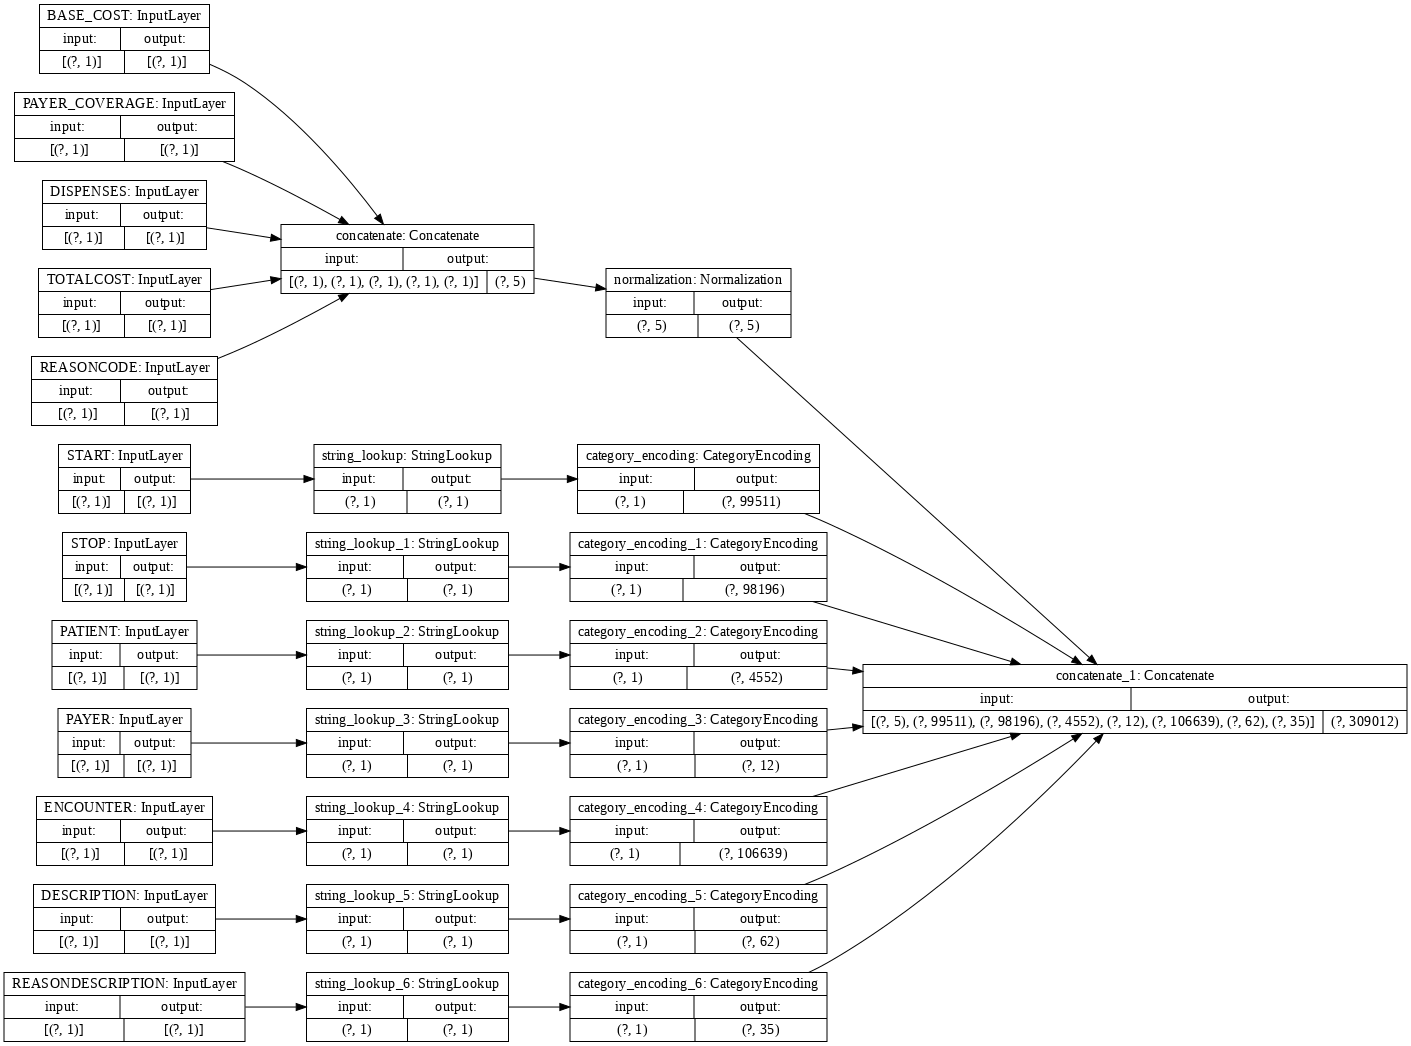

In [17]:
preprocessed_inputs_cat = layers.Concatenate()(preprocessed_inputs)

synthea_preprocessing = tf.keras.Model(inputs, preprocessed_inputs_cat)

tf.keras.utils.plot_model(model = synthea_preprocessing , rankdir="LR", dpi=72, show_shapes=True)

This `model` just contains the input preprocessing. You can run it to see what it does to your data. Keras models don't automatically convert Pandas `DataFrames` because it's not clear if it should be converted to one tensor or to a dictionary of tensors. So convert it to a dictionary of tensors:

In [18]:
synthea_features_dict = {name: np.array(value) 
                         for name, value in synthea_features.items()}

Slice out the first training example and pass it to this preprocessing model, you see the numeric features and string one-hots all concatenated together:

In [19]:
features_dict = {name:values[:1] for name, values in synthea_features_dict.items()}
synthea_preprocessing(features_dict)

<tf.Tensor: shape=(1, 309012), dtype=float32, numpy=
array([[-0.191, -0.136, -0.726, ...,  0.   ,  0.   ,  1.   ]],
      dtype=float32)>

Now build the model on top of this:

In [20]:
def synthea_model(preprocessing_head, inputs):
  body = tf.keras.Sequential([
    layers.Dense(64),
    layers.Dense(1)
  ])

  preprocessed_inputs = preprocessing_head(inputs)
  result = body(preprocessed_inputs)
  model = tf.keras.Model(inputs, result)

  model.compile(loss=tf.losses.BinaryCrossentropy(from_logits=True),
                optimizer=tf.optimizers.Adam())
  return model

synthea_model = synthea_model(synthea_preprocessing, inputs)

When you train the model, pass the dictionary of features as `x`, and the label as `y`.

In [21]:
synthea_model.fit(x=synthea_features_dict, y=synthea_labels, epochs=10)

Epoch 1/10
6095/6095 [==============================] - 89s 15ms/step - loss: -3017927680.0000
Epoch 2/10
6095/6095 [==============================] - 87s 14ms/step - loss: -17254270976.0000
Epoch 3/10
6095/6095 [==============================] - 87s 14ms/step - loss: -41967202304.0000
Epoch 4/10
6095/6095 [==============================] - 87s 14ms/step - loss: -76612575232.0000
Epoch 5/10
6095/6095 [==============================] - 86s 14ms/step - loss: -121160646656.0000
Epoch 6/10
6095/6095 [==============================] - 86s 14ms/step - loss: -175352283136.0000
Epoch 7/10
6095/6095 [==============================] - 85s 14ms/step - loss: -239183183872.0000
Epoch 8/10
6095/6095 [==============================] - 85s 14ms/step - loss: -312897077248.0000
Epoch 9/10
6095/6095 [==============================] - 85s 14ms/step - loss: -396135432192.0000
Epoch 10/10
6095/6095 [==============================] - 85s 14ms/step - loss: -489054306304.0000


Since the preprocessing is part of the model, you can save the model and reload it somewhere else and get identical results:

In [22]:
synthea_model.save('test')
reloaded = tf.keras.models.load_model('test')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: test/assets


In [23]:
features_dict = {name:values[:1] for name, values in synthea_features_dict.items()}

before = synthea_model(features_dict)
after = reloaded(features_dict)
assert (before-after)<1e-3
print(before)
print(after)

tf.Tensor([[795121.1]], shape=(1, 1), dtype=float32)
tf.Tensor([[795121.1]], shape=(1, 1), dtype=float32)
